In [1]:
import nltk
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu, modified_precision
from nltk.translate.chrf_score import sentence_chrf, corpus_chrf
from nltk.metrics import scores
import scipy.io.wavfile
from IPython.display import Audio
from IPython.display import display
from nltk.stem import *
# from nltk.stem.snowball import SnowballStemmer
from stemming.porter2 import stem
import stemming
from nltk.metrics.scores import recall

%matplotlib inline

In [2]:
from nmt_run import *

fisher + callhome sp/es - en configuration
--------------------------------------------------
loading info_dict from=./callhome_fbank_out/info.dict


 37%|███▋      | 51626/138708 [00:00<00:00, 516259.26it/s]

--------------------------------------------------
creating buckets for: fisher_dev
creating buckets for key: sp
creating buckets for: fisher_dev2
creating buckets for key: sp
creating buckets for: fisher_test
creating buckets for key: sp
creating buckets for: fisher_train
creating buckets for key: sp


100%|██████████| 14284/14284 [00:00<00:00, 517597.89it/s]


creating buckets for: callhome_devtest
creating buckets for key: sp
creating buckets for: callhome_evltest
creating buckets for key: sp
creating buckets for: callhome_train
creating buckets for key: sp
--------------------------------------------------
saving info dict in: ./callhome_fbank_out/buckets_sp.dict
all done ...
--------------------------------------------------
showing buckets for category: fisher_dev
number of buckets=10, width of each bucket=150
index | width | num   
    0 |     0 |   1039
    1 |   150 |   1006
    2 |   300 |    614
    3 |   450 |    400
    4 |   600 |    315
    5 |   750 |    246
    6 |   900 |    159
    7 |  1050 |    113
    8 |  1200 |     49
    9 |  1350 |     36
--------------------------------------------------
showing buckets for category: fisher_dev2
number of buckets=10, width of each bucket=150
index | width | num   
    0 |     0 |    853
    1 |   150 |   1095
    2 |   300 |    685
    3 |   450 |    447
    4 |   600 |    278
    5 

/afs/inf.ed.ac.uk/group/project/lowres/work/anaconda3/envs/chainer3/lib/python3.6/site-packages/chainer/utils/experimental.py:104: FutureWarning: chainer.links.normalization.layer_normalization.py is experimental. The interface can change in the future.
  FutureWarning)


using ADAM optimizer


In [3]:
model_files = [f for f in os.listdir(os.path.dirname(model_fil))
                   if os.path.basename(model_fil).replace('.model','') in f]
# print(model_files)

In [4]:
max_model_fil = max(model_files, key=lambda s: int(s.split('_')[-1].split('.')[0]))

In [5]:
max_model_fil

'seq2seq_sen-138819_hwy0-dec3_emb-256-h-256__full1__sp_en_w_gru_drpt-0.3_noise-0_l2-0.001000_32_32_2_2_2DCNN_BN_LN_enc-3_67.model'

In [6]:
last_epoch = check_model()

--------------------------------------------------------------------------------
model found = 
fsh_fbank/seq2seq_sen-138819_hwy0-dec3_emb-256-h-256__full1__sp_en_w_gru_drpt-0.3_noise-0_l2-0.001000_32_32_2_2_2DCNN_BN_LN_enc-3_67.model
loading ...
finished loading ..


In [7]:
log_dev_fil_name

'fsh_fbank/dev_sen-138819_hwy0-dec3_emb-256-h-256__full1__sp_en_w_gru_drpt-0.3_noise-0_l2-0.001000_32_32_2_2_2DCNN_BN_LN_enc-3.log'

In [8]:
log_train = np.loadtxt(log_train_fil_name, delimiter=',', skiprows=False).transpose()
log_test = np.genfromtxt(log_dev_fil_name, delimiter=',', usecols = (0,1,2)).transpose()

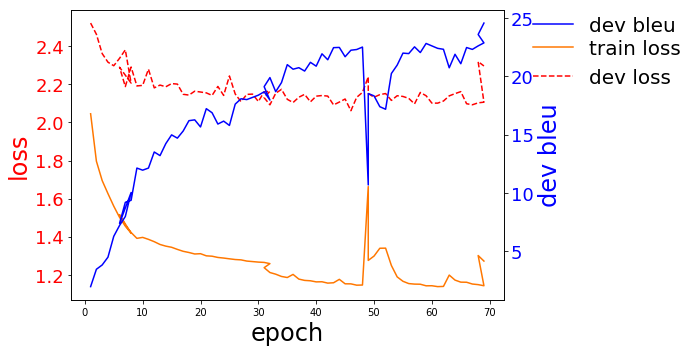

In [9]:
fig, ax1 = plt.subplots()
fig.set_size_inches(8,5)
ax1.plot(log_train[0], log_train[1], color='#ff7700')
ax1.plot(log_test[0], log_test[1], 'r--')
ax1.set_xlabel('epoch', size=24)
ax1.set_ylabel('loss', color='r', size=24)
for tl in ax1.get_yticklabels():
    tl.set_color('r')
    tl.set_fontsize(18)
plt.legend(['train loss', 'dev loss'], bbox_to_anchor=(1.45, 0.96), framealpha=0, fontsize=20)    
ax2 = ax1.twinx()
ax2.plot(log_test[0], log_test[2]*100, 'b-')
ax2.set_xlabel('iteration')
ax2.set_ylabel('dev bleu', color='b', size=24)
# ax1.set_xlim(0, 60)
for tl in ax2.get_yticklabels():
    tl.set_color('b')
    tl.set_fontsize(18) 
plt.legend(['dev bleu'], bbox_to_anchor=(1.44, 1.04), framealpha=0, fontsize=20)
# plt.legend(['dev bleu'], bbox_to_anchor=(1.06, 0.9), framealpha=0, fontsize=20)
plt.grid(False)
plt.tight_layout()

In [10]:
import nltk.translate.bleu_score

In [11]:
def play_utt(utt, m_dict):
    sr, y = scipy.io.wavfile.read(os.path.join(wavs_path, utt.rsplit("-",1)[0]+'.wav'))
    start_t = min(seg['start'] for seg in m_dict[utt]['seg'])
    end_t = max(seg['end'] for seg in m_dict[utt]['seg'])
    print(start_t, end_t)
    start_t_samples, end_t_samples = int(start_t*sr), int(end_t*sr)
    display(Audio(y[start_t_samples:end_t_samples], rate=sr))

In [12]:
def display_words(m_dict, v_dict, preds, utts, dec_key, key, play_audio=False, displayN=50):
    es_ref = []
    en_ref = []
    for u in utts:
        es_ref.append(" ".join([w.decode() for w in m_dict[u]['es_w']]))
        if type(m_dict[u][dec_key]) == list:
            en_ref.append(" ".join([w.decode() for w in m_dict[u]['en_w']]))
        else:
            en_ref.append(" ".join([w.decode() for w in m_dict[u]['en_w'][0]]))

    en_pred = []
    join_str = ' ' if dec_key.endswith('_w') else ''

    for p in preds:
        t_str = join_str.join([v_dict['i2w'][i].decode() for i in p])
        t_str = t_str[:t_str.find('_EOS')]
        en_pred.append(t_str)

    for u, es, en, p in zip(utts, es_ref, en_ref, en_pred):
        # for reference, 1st word is GO_ID, no need to display
        print("Utterance: {0:s}".format(u))
        display_pp = PrettyTable(["cat","sent"], hrules=True)
        display_pp.align = "l"
        display_pp.header = False
        display_pp.add_row(["es ref", textwrap.fill(es,50)])
        display_pp.add_row(["en ref", textwrap.fill(en,50)])
        display_pp.add_row(["en pred", textwrap.fill(p,50)])

        print(display_pp)
        if play_audio:
            play_utt(u, m_dict)
    

In [13]:
def display_words_latex(m_dict, v_dict, preds, utts, dec_key):
    print("min length={0:d}, max length={1:d}".format(min_len, max_len))
    es_ref = []
    en_ref = []
    for u in utts:
        es_ref.append(" ".join([w.decode() for w in m_dict[u]['es_w']]))
        if type(m_dict[u][dec_key]) == list:
            en_ref.append(" ".join([w.decode() for w in m_dict[u]['en_w']]))
        else:
            en_ref.append(" ".join([w.decode() for w in m_dict[u]['en_w'][0]]))

    en_pred = []
    join_str = ' ' if dec_key.endswith('_w') else ''

    for p in preds:
        t_str = join_str.join([v_dict['i2w'][i].decode() for i in p])
        t_str = t_str[:t_str.find('_EOS')]
        en_pred.append(t_str)

    total_matching_len = 0

    for u, es, en, p in zip(utts, es_ref, en_ref, en_pred):
        # for reference, 1st word is GO_ID, no need to display
        print("Utterance: {0:s}".format(u))
        print("{0:d} & {1:s} & {2:s} & {3:s} \\\\".format(total_matching_len, es, en, p))



In [14]:
def write_predictions_to_file(m_dict, v_dict, preds, utts, dec_key, key, stemmify=False):
    en_hyp = []
    en_ref = []
    ref_key = 'en_w' if 'en_' in dec_key else 'es_w'
    src_key = 'es_w'
    
    for u in tqdm(utts, ncols=80):
        if type(m_dict[u][ref_key]) == list:
            if stemmify:
                en_ref.append(" ".join([stem(w.decode()) for w in m_dict[u]['en_w']]))
            else:
                en_ref.append(" ".join([w.decode() for w in m_dict[u]['en_w']]))
        else:
            en_r_list = []
            for r in m_dict[u][ref_key]:
                if stemmify:
                    en_r_list.append(" ".join([stem(w.decode()) for w in r]))
                else:
                    en_r_list.append(" ".join([w.decode() for w in r]))
            en_ref.append(en_r_list)

    join_str = ' ' if dec_key.endswith('_w') else ''

    total_matching_len = 0

    for u, p in zip(utts, preds):
        if stemmify:
            t_str = join_str.join([stem(v_dict['i2w'][i].decode()) if i != EOS_ID else EOS.decode() for i in p])
        else:
            t_str = join_str.join([v_dict['i2w'][i].decode() for i in p])
        t_str = t_str[:t_str.find('_EOS')]
        en_hyp.append(t_str)

    
    print("writing to file: {0:s}".format("{0:s}_mt-output".format(key)))
    with open("{0:s}_mt-output".format(key), "w") as pred_f:
        for p in en_hyp:
            pred_f.write("{0:s}\n".format(p))
        # end for
    # end while
    
    if type(m_dict[utts[0]][ref_key]) == list:
        with open("{0:s}.ref0".format(key), "w") as ref_f:
            for r in en_ref:
                ref_f.write("{0:s}\n".format(r))
    else:
        num_ref = len(m_dict[u][ref_key])
        for i in range(num_ref):
            with open("{0:s}_en.ref{1:d}".format(key,i), "w") as ref_f:
                for r in en_ref:
                    ref_f.write("{0:s}\n".format(r[i]))
                # end for each utt
            # end with
        # end for reference
    # end else
    print("done")
    return en_ref, en_hyp

### Fisher dev

In [152]:
key='fisher_dev'
train=False
m_dict = map_dict[key]
v_dict = vocab_dict[dec_key]
n=len(map_dict[key])
BATCH_SIZE = 256

In [153]:
cat_speech_path = os.path.join(out_path, key)
wavs_path = os.path.join(out_path, "wavs")

In [154]:
print("-"*80)
print("EPOCH = {0:d}".format(last_epoch+1))
fsh_pred_sents, fsh_utts, loss = feed_model(map_dict[key],
                  b_dict=bucket_dict[key],
                  vocab_dict=vocab_dict,
                  batch_size=BATCH_SIZE,
                  x_key=enc_key,
                  y_key=dec_key,
                  train=train,
                  cat_speech_path=cat_speech_path, use_y=True, mini=False)

print("{0:s} {1:s} mean loss={2:.4f}".format("*" * 10,
                                    "train" if train else "dev",
                                    loss))
print("-")
print("-"*80)

  0%|                                                  | 0/3977 [00:00<?, ?it/s]

--------------------------------------------------------------------------------
EPOCH = 68


b=3,l=1.79,avg=2.36: 100%|██████████████████| 3977/3977 [00:46<00:00, 61.20it/s]

********** dev mean loss=2.3581
-
--------------------------------------------------------------------------------


In [155]:
# Eval parameters
ref_index = -1
min_len, max_len= 0, MAX_EN_LEN
min_len, max_len= 5, 50
displayN = 50

In [161]:
fsh_filt_pred, fsh_filt_utts = zip(*[(p,u) for p, u in zip(fsh_pred_sents, fsh_utts) if (len(m_dict[u]['es_w']) >= min_len) and 
                                        (len(m_dict[u]['es_w']) <= max_len)])

In [164]:
print("length filtered utterances = {0:d}".format(len(fsh_filt_utts)))

length filtered utterances = 2343


In [165]:
display_words(m_dict, v_dict, fsh_filt_pred, fsh_filt_utts, 
              dec_key, key, play_audio=False, displayN=displayN)

Utterance: 20051016_180547_265_fsp-A-33
+---------+------------------------------------------------+
| es ref  | y yo le digo hay ernestina josefina y entonces |
+---------+------------------------------------------------+
| en ref  | and i tell her oh ernestina josefina and then  |
+---------+------------------------------------------------+
| en pred | and the same are you born in austin            |
+---------+------------------------------------------------+
Utterance: 20051025_212334_337_fsp-B-25
+---------+-------------------------+
| es ref  | ah no yo vivo en canadá |
+---------+-------------------------+
| en ref  | ah no i live in canada  |
+---------+-------------------------+
| en pred | ah i live in canada     |
+---------+-------------------------+
Utterance: 20051026_180724_341_fsp-B-53
+---------+----------------------------------------------------+
| es ref  | nunca di- nunca cambian i don t know why you       |
|         | should change it                             

+---------+----------------------------------------------------+
| es ref  | entonces a ver que nos decía la maestra y la       |
|         | maestra dio un buen informé de la niña porque mi   |
|         | niña es una niña muy buena que tiene un corazón    |
|         | bueno y                                            |
+---------+----------------------------------------------------+
| en ref  | then lets see what the teacher told us and the     |
|         | teacher gave a a good report on the girl because   |
|         | my girl is a good girl she has a good heart and    |
+---------+----------------------------------------------------+
| en pred | then sometimes you don t know that they don t want |
|         | to do that and the rest well they only put it      |
|         | because my kids are very good and                  |
+---------+----------------------------------------------------+
Utterance: 20051018_210220_279_fsp-B-47
+---------+---------------------------------------

Utterance: 20051009_182032_217_fsp-B-147
+---------+--------------------------------------------+
| es ref  | pero mi tío es los siete días de la semana |
+---------+--------------------------------------------+
| en ref  | but my uncle goes seven days a week        |
+---------+--------------------------------------------+
| en pred | but my son is from the week                |
+---------+--------------------------------------------+
Utterance: 20051019_230329_292_fsp-B-1
+---------+--------------------------+
| es ref  | buenas noches yo soy joe |
+---------+--------------------------+
| en ref  | good night i am joe      |
+---------+--------------------------+
| en pred | good evening i m joe     |
+---------+--------------------------+
Utterance: 20051026_180724_341_fsp-A-39
+---------+-----------------------------+
| es ref  | yo no me caen bien          |
+---------+-----------------------------+
| en ref  | and i i don t like them     |
+---------+-----------------------------

Utterance: 20051018_210744_280_fsp-B-54
+---------+----------------------------------------------------+
| es ref  | así que tu sabes siempre es n- no es el calor      |
|         | tanto como la humedad yo creo                      |
+---------+----------------------------------------------------+
| en ref  | so you know always it s n- not the heat as much as |
|         | the humidity i believe                             |
+---------+----------------------------------------------------+
| en pred | so you know always is not hot as a humidity i      |
|         | think                                              |
+---------+----------------------------------------------------+
Utterance: 20051022_180817_311_fsp-A-71
+---------+--------------------------------------------------+
| es ref  | sí el arpa es bien bonito sabe lo que me gusta   |
|         | también la música de acordeón me encanta también |
+---------+--------------------------------------------------+
| en ref  | yeah t

Utterance: 20051026_180724_341_fsp-A-94
+---------+-------------------------------------------------+
| es ref  | porque yo tengo primas que me dan verguenzas    |
|         | porque son sluts basically                      |
+---------+-------------------------------------------------+
| en ref  | because i have cousins that make me ashamed     |
|         | because they re sluts basically                 |
+---------+-------------------------------------------------+
| en pred | because i have the first crime because they are |
|         | the                                             |
+---------+-------------------------------------------------+
Utterance: 20051017_234550_276_fsp-B-126
+---------+---------------------------------------------------+
| es ref  | ¿ no no merengue ni salsa ni ni ni ni reguetón ni |
|         | nada ¿ solamente es reguetón                      |
+---------+---------------------------------------------------+
| en ref  | no not merengue or salsa not no

Utterance: 20051016_180547_265_fsp-A-37
+---------+----------------------------------------------------+
| es ref  | de allí del caribe que tiene un idioma especial y  |
|         | no algo así es                                     |
+---------+----------------------------------------------------+
| en ref  | from the caribbean that has a special language and |
|         | something like that                                |
+---------+----------------------------------------------------+
| en pred | and the caribbean has more than more than less     |
|         | something like that                                |
+---------+----------------------------------------------------+
Utterance: 20051009_182032_217_fsp-B-145
+---------+--------------------------------------------------+
| es ref  | tengo una amiga que ella es cristiana y ella     |
|         | solamente ella dice que va a la iglesia          |
+---------+--------------------------------------------------+
| en ref  | i hav

+---------+--------------------------------------------------+
| es ref  | pero tu sabes donde quiera vas a encontrar gente |
|         | buena y gente mala                               |
+---------+--------------------------------------------------+
| en ref  | but you know wherever you go you ll gonna find   |
|         | good and bad people                              |
+---------+--------------------------------------------------+
| en pred | but you know where you want to buy people well   |
|         | people                                           |
+---------+--------------------------------------------------+
Utterance: 20051018_210744_280_fsp-B-12
+---------+----------------------------------------------+
| es ref  | y estoy esperando otro bebé en dos semanas   |
+---------+----------------------------------------------+
| en ref  | and i am expecting another baby in two weeks |
+---------+----------------------------------------------+
| en pred | i m waiting or two week

In [166]:
os.chdir("..")
os.chdir("/afs/inf.ed.ac.uk/group/project/lowres/work/chainer2/speech2text")

In [167]:
b, chrf, h, r = calc_bleu(m_dict, 
                          v_dict, 
                          fsh_filt_pred, 
                          fsh_filt_utts, 
                          dec_key, 
                          ref_index=ref_index)

print("BLEU score on: {0:s} = {1:.2f}".format(key, b * 100))
print("-"*60)

model_refs = {u: mr for u, mr in zip(fsh_filt_utts, r)}
model_hyps = {u: mh for u, mh in zip(fsh_filt_utts, h)}
    

# chrf = [0]*4

# for ref_i in range(4):
#     _, chrf[ref_i], _, _ = calc_bleu(m_dict, 
#                               v_dict, 
#                               fsh_pred_sents[:n], 
#                               fsh_utts[:n], 
#                               dec_key, 
#                               min_len=min_len, 
#                               max_len=max_len, ref_index=ref_i)
#     # end for

# # print chrf score
# for i in range(4):
#     print("CHRF score on: {0:s} = {1:.2f}, using reference = {2:d}".format(key, chrf[i] * 100, i))

# print("-"*60)

all_weights=[(1.,0.,0.,0.),
             (0.,1.,0.,0.),
             (0.,0.,1.,0.),
             (0.,0.,0.,1.),
             (1./2,1./2,0.,0.),
             (1./3,1./3,1./3,0.),
             (.25,.25,.25,.25)]

100%|████████████████████████████████████| 2343/2343 [00:00<00:00, 29779.74it/s]


BLEU score on: fisher_dev = 22.60
------------------------------------------------------------


In [168]:
# list(zip(h,r[:5]))

In [169]:
smooth_fun = nltk.translate.bleu_score.SmoothingFunction()

In [170]:
# print("{0:>20s} | {1:20s}".format("bleu score (0-100)", "uni-bi-tri-quad"))
# for weights in all_weights:
#     b = corpus_bleu(r, h, weights=weights, smoothing_function=smooth_fun.method2)
#     print("{0:20.2f} | {1:20s}".format(b * 100, "-".join(map("{0:.2f}".format, weights))))

In [171]:
list(model_refs.values())[3]

[['such',
  'um',
  'like',
  'when',
  'he',
  'made',
  'himself',
  'a',
  'citizen',
  'here'],
 ['his', 'uh', 'like', 'when', 'he', 'got', 'his', 'citizenship'],
 ['his', 'like', 'how', 'when', 'he', 'became', 'a', 'citizen', 'here'],
 ['sus', 'uhm', 'like', 'how', 'when', 'he', 'became', 'a', 'citizen', 'here']]

In [146]:
# pred_path = "/afs/inf.ed.ac.uk/group/project/lowres/work/installs/fisher-callhome-corpus/corpus/ldc"
# pred_fname = os.path.join(pred_path, "fisher_dev.pred")

In [173]:
key

'fisher_dev'

In [175]:
en_ref, en_hyp = write_predictions_to_file(m_dict, v_dict, fsh_filt_pred, fsh_filt_utts, 
                                           dec_key, key, stemmify=False)

100%|████████████████████████████████████| 2343/2343 [00:00<00:00, 26508.42it/s]

writing to file: fisher_dev_mt-output
done


In [176]:
len(en_hyp)

2343

In [177]:
_, _ = corpus_precision_recall(r, h)

total utts=2343
metric     |   1-gram |   2-gram|   3-gram |   4-gram
------------------------------------------------------
precision  |    58.91 |    31.27|    17.16 |     9.56
recall     |    30.94 |    11.86|     5.46 |     2.73


### Callhome dev

In [151]:
key='callhome_devtest'
train=False
m_dict = map_dict[key]
v_dict = vocab_dict[dec_key]
n=len(map_dict[key])
BATCH_SIZE = 256

In [ ]:
cat_speech_path = os.path.join(out_path, key)

In [ ]:
print("-"*80)
print("EPOCH = {0:d}".format(last_epoch+1))
call_pred_sents, call_utts, loss = feed_model(map_dict[key],
                  b_dict=bucket_dict[key],
                  vocab_dict=vocab_dict,
                  batch_size=BATCH_SIZE,
                  x_key=enc_key,
                  y_key=dec_key,
                  train=train,
                  cat_speech_path=cat_speech_path, use_y=True)

print("{0:s} {1:s} mean loss={2:.4f}".format("*" * 10,
                                    "train" if train else "dev",
                                    loss))
print("-")
print("-"*80)

In [ ]:
display_words(m_dict, v_dict, call_pred_sents[:displayN], call_utts[:displayN],
              dec_key, key, min_len=min_len, max_len=max_len, play_audio=False)

In [ ]:
b, _, h, r = calc_bleu(m_dict, 
                              v_dict, 
                              call_pred_sents, 
                              call_utts, 
                              dec_key, 
                              min_len=min_len, 
                              max_len=max_len, 
                              ref_index=ref_index)

print("BLEU score on: {0:s} = {1:.2f}".format(key, b * 100))
print("-"*60)

all_weights=[(1.,0.,0.,0.),
             (0.,1.,0.,0.),
             (0.,0.,1.,0.),
             (0.,0.,0.,1.),
             (1./2,1./2,0.,0.),
             (1./3,1./3,1./3,0.),
             (.25,.25,.25,.25)]

In [ ]:
smooth_fun = nltk.translate.bleu_score.SmoothingFunction()

In [ ]:
print("{0:>20s} | {1:20s}".format("bleu score (0-100)", "uni-bi-tri-quad"))
for weights in all_weights:
    b = corpus_bleu(r, h, weights=weights, smoothing_function=smooth_fun.method2)
    print("{0:20.2f} | {1:20s}".format(b * 100, "-".join(map("{0:.2f}".format, weights))))

In [ ]:
_, _ = corpus_precision_recall(r, h)

In [ ]:
call_en_ref, call_en_hyp = write_predictions_to_file(m_dict, v_dict, call_pred_sents, call_utts, 
                                                     dec_key, key, min_len=min_len, max_len=max_len, stemmify=False)

In [ ]:
len(call_en_ref),len(call_en_hyp)

### Google metrics

In [178]:
google_s2t_path_hyps = "./google-s2t/e2e_ast_decode/hyps/fisher_dev/"
google_s2t_path_refs = "./google-s2t/e2e_ast_decode/refs/fisher_dev/"
google_hyp_fname = 'fisher_spa_eng_ast_003_base_r0.txt'

### Prep Google data

In [179]:
kaldi_segment_map_path = os.path.join(out_path,'kaldi_segment_map.dict')
rev_map_dict_path = os.path.join(out_path,'rev_map.dict')
kaldi_segment_map = pickle.load(open(kaldi_segment_map_path, "rb"))
rev_map_dict = pickle.load(open(rev_map_dict_path, "rb"))


google_s2t_path_mapping = "./google-s2t/e2e_ast_decode/mapping/fisher_dev/"
google_s2t_ref0 = os.path.join(google_s2t_path_mapping, "sorted-normalized-fisher_dev.en.0.mapping")

google_s2t_map_path = os.path.join(out_path, "google_s2t_map.dict")
google_s2t_rev_map_path = os.path.join(out_path, "google_s2t_rev_map.dict")
google_s2t_refs_path = os.path.join(out_path, "google_s2t_refs.dict")
google_s2t_hyps_path = os.path.join(out_path, "google_s2t_hyps.dict")

In [180]:
def prep_google_data():

    google_s2t_map = {}
    google_s2t_rev_map = {}

    r_m_dict = rev_map_dict['fisher_dev']
    with open(google_s2t_ref0, "r") as in_f:
        for i, line in enumerate(in_f, start=1):
            wav_f = line.split(".wav")[0].replace("fisher_dev/", "")
            key_1 = wav_f[:wav_f.find("_fsp")+len("_fsp")]
            key_2 = wav_f.rsplit("_fsp",1)[1].split("_")[0]
            google_s2t_map[i] = r_m_dict[key_1+key_2]
            google_s2t_rev_map[r_m_dict[key_1+key_2]] = i
        # end for
    # end with
    pickle.dump(google_s2t_map, open(google_s2t_map_path, "wb"))
    pickle.dump(google_s2t_rev_map, open(google_s2t_rev_map_path, "wb"))
    
    google_s2t_refs = {}
    for fname in os.listdir(google_s2t_path_refs):
        with open(os.path.join(google_s2t_path_refs,fname), "r") as in_f:
            f_key = fname.rsplit("-",1)[-1].replace(".en.","_ref_")
            google_s2t_refs[f_key] = {}
            for i, line in enumerate(in_f, start=1):
                utt_key = google_s2t_map[i]
                google_s2t_refs[f_key][utt_key] = line.rstrip('\n').split()
            # end for
        # end with
    # end for
    pickle.dump(google_s2t_refs, open(google_s2t_refs_path, "wb"))
    
    google_s2t_hyps = {}
    for fname in os.listdir(google_s2t_path_hyps):
        with open(os.path.join(google_s2t_path_hyps,fname), "r") as in_f:
            f_key = "fisher_dev_{0:s}".format(fname.rsplit("_")[-1].replace(".txt", ""))
            google_s2t_hyps[f_key] = {}
            for i, line in enumerate(in_f, start=1):
                utt_key = google_s2t_map[i]
                google_s2t_hyps[f_key][utt_key] = line.rstrip('\n').split()
            # end for
        # end with
    # end for
    pickle.dump(google_s2t_hyps, open(google_s2t_hyps_path, "wb"))
    return google_s2t_refs, google_s2t_hyps

In [181]:
"." in fsh_utts

False

In [182]:
def write_google_s2t_refs_to_file(google_dict, utts):
    data_lines = {}
    for r in google_dict.keys():
        curr_file_lines = []
        out_fname = "google_"+r+".en"
        with open(out_fname, "w") as out_f:
            print("writing to file: {0:s}".format(out_fname))
            for utt_id in utts:
                words = " ".join(google_dict[r][utt_id])
                out_line = "{0:s}\n".format(words)
                out_f.write(out_line)
                if utt_id not in data_lines:
                    if len(google_dict) > 1:
                        data_lines[utt_id] = [google_dict[r][utt_id]]
                    else:
                        data_lines[utt_id] = google_dict[r][utt_id][:]
                else:
                    data_lines[utt_id].append(google_dict[r][utt_id])
            # end for over utterances
        # end for file        
    # end with
    return data_lines

In [183]:
google_s2t_refs, google_s2t_hyps = prep_google_data()

In [184]:
hyp_key = 'fisher_dev_r0'
google_refs = write_google_s2t_refs_to_file(google_s2t_refs, fsh_filt_utts)
google_hyps = write_google_s2t_refs_to_file({hyp_key : google_s2t_hyps[hyp_key]}, fsh_filt_utts)

writing to file: google_fisher_dev_ref_3.en
writing to file: google_fisher_dev_ref_2.en
writing to file: google_fisher_dev_ref_1.en
writing to file: google_fisher_dev_ref_0.en
writing to file: google_fisher_dev_r0.en


In [185]:
list(google_hyps.values())[0], list(model_hyps.values())[0]

(['and', 'reggae', 'ernestina', 'is', 'another', 'like', 'that', 'then'],
 ['and', 'the', 'same', 'are', 'you', 'born', 'in', 'austin'])

In [186]:
" ".join(map(lambda t: t.decode(), m_dict[rev_map_dict['fisher_dev']['20051009_182032_217_fsp.108']]['en_w'][0]))

'and my dad always taught us that that for you to be to believe in god you don t have to be involved with a church'

In [187]:
print(" ".join([w for w in google_s2t_refs['fisher_dev_ref_0'][fsh_utts[0]]]))
print(" ".join([w for w in google_s2t_hyps['fisher_dev_r0'][fsh_utts[0]]]))
print(" ".join([w for w in h[0]]))

and i tell her oh ernestina josefina and then
and reggae ernestina is another like that then
and the same are you born in austin


In [188]:
print(len(fsh_utts), len(google_s2t_refs['fisher_dev_ref_0']))

for key in google_s2t_refs['fisher_dev_ref_0']:
    if key not in fsh_utts:
        print(key)
        print(" ".join([w.decode() for w in m_dict[key]['en_w'][0]]))
        print(google_s2t_hyps['fisher_dev_r0']['20051017_220530_275_fsp-B-26'])

3977 3979
20051017_220530_275_fsp-B-21
nothing above in spanish--
['yeah']
20051017_220530_275_fsp-B-26
no words in spanish here lol
['yeah']


In [189]:
google_s2t_refs.keys(), google_s2t_hyps.keys()

(dict_keys(['fisher_dev_ref_3', 'fisher_dev_ref_2', 'fisher_dev_ref_1', 'fisher_dev_ref_0']),
 dict_keys(['fisher_dev_r2', 'fisher_dev_r1', 'fisher_dev_r0']))

In [190]:
google_prec_recall = {'precision' : {}, 'recall' : {}, "tp": 0, "tc": 0, "tr": 0}
model_prec_recall = {'precision' : {}, 'recall' : {}, "tp": 0, "tc": 0, "tr": 0}


for utt_id, ref, hyp in zip(fsh_filt_utts, r, h):
    es_ref = [w.decode() for w in m_dict[utt_id]['es_w']]
    
    pval, rval = modified_precision_recall([google_s2t_refs[i][utt_id] for i in google_s2t_refs], 
                                           google_s2t_hyps['fisher_dev_r0'][utt_id], n=1)

    google_prec_recall['precision'][utt_id] = float(pval)
    google_prec_recall['recall'][utt_id] = float(rval)

    google_prec_recall['tc'] += pval.numerator
    google_prec_recall['tp'] += pval.denominator
    google_prec_recall['tr'] += rval.denominator

    if rval > 1:
        print("ouch", utt_id)
        break

    pval, rval = modified_precision_recall(ref, hyp, n=1)
    model_prec_recall['tc'] += pval.numerator
    model_prec_recall['tp'] += pval.denominator
    model_prec_recall['tr'] += rval.denominator

    model_prec_recall['precision'][utt_id] = float(pval)
    model_prec_recall['recall'][utt_id] = float(rval)
# end for
    
google_prec_recall['total_precision'] = google_prec_recall['tc'] / google_prec_recall['tp']
google_prec_recall['total_recall'] = google_prec_recall['tc'] / google_prec_recall['tr']
model_prec_recall['total_precision'] = model_prec_recall['tc'] / model_prec_recall['tp']
model_prec_recall['total_recall'] = model_prec_recall['tc'] / model_prec_recall['tr']

In [191]:
print("\t\tGoogle metrics")
print("-"*60)
print("{0:10s} = {1:0.3f}\n{2:10s} = {3:0.3f}".format("precision",
                                                      google_prec_recall['total_precision'],
                                                      "recall",
                                                      google_prec_recall['total_recall']))

		Google metrics
------------------------------------------------------------
precision  = 0.772
recall     = 0.431


In [192]:
print("\t\tModel metrics")
print("-"*60)
print("{0:10s} = {1:0.3f}\n{2:10s} = {3:0.3f}".format("precision",
                                                      model_prec_recall['total_precision'],
                                                      "recall",
                                                      model_prec_recall['total_recall']))


		Model metrics
------------------------------------------------------------
precision  = 0.589
recall     = 0.309


In [193]:
list(google_refs.values())[:2], list(model_refs.values())[:2]

([[['and', 'i', 'tell', 'her', 'ernestina', 'josefina', 'so', 'then'],
   ['and',
    'i',
    'tell',
    'her',
    'there',
    'is',
    'ernestina',
    'josefina',
    'and',
    'then'],
   ['and',
    'i',
    'tell',
    'her',
    'there',
    'is',
    'ernestina',
    'josefina',
    'and',
    'then'],
   ['and', 'i', 'tell', 'her', 'oh', 'ernestina', 'josefina', 'and', 'then']],
  [['ah', 'i', 'live', 'in', 'canada'],
   ['ah', 'no', 'i', 'live', 'in', 'canada'],
   ['ah', 'no', 'i', 'live', 'in', 'canada'],
   ['ah', 'no', 'i', 'live', 'in', 'canada']]],
 [[['and', 'i', 'tell', 'her', 'oh', 'ernestina', 'josefina', 'and', 'then'],
   ['and',
    'i',
    'tell',
    'her',
    'there',
    'is',
    'ernestina',
    'josefina',
    'and',
    'then'],
   ['and',
    'i',
    'tell',
    'her',
    'there',
    'is',
    'ernestina',
    'josefina',
    'and',
    'then'],
   ['and', 'i', 'tell', 'her', 'ernestina', 'josefina', 'so', 'then']],
  [['ah', 'no', 'i', 'live',

In [194]:
"{0:0.3f}".format(corpus_bleu(google_refs.values(), google_hyps.values()))

'0.465'

In [195]:
for i in range(len(list(google_refs.values())[0])):
    print("chrf score using ref:{0:d} = {1:5.3f}".format(i+1, corpus_chrf([ref[i] 
                                                                           for ref in google_refs.values()], 
                                                                          google_hyps.values())))

chrf score using ref:1 = 0.702
chrf score using ref:2 = 0.673
chrf score using ref:3 = 0.633
chrf score using ref:4 = 0.510


In [196]:
for i in range(len(list(model_refs.values())[0])):
    print("chrf score using ref:{0:d} = {1:5.3f}".format(i+1, corpus_chrf([x[i] for x in model_refs.values()], 
                                                                          model_hyps.values())))

chrf score using ref:1 = 0.221
chrf score using ref:2 = 0.219
chrf score using ref:3 = 0.341
chrf score using ref:4 = 0.266


In [197]:
_, _ = corpus_precision_recall(google_refs.values(), google_hyps.values())

total utts=2343
metric     |   1-gram |   2-gram|   3-gram |   4-gram
------------------------------------------------------
precision  |    77.22 |    55.40|    39.47 |    27.92
recall     |    43.11 |    22.45|    13.52 |     8.64


In [198]:
_, _ = corpus_precision_recall(model_refs.values(), model_hyps.values())

total utts=2343
metric     |   1-gram |   2-gram|   3-gram |   4-gram
------------------------------------------------------
precision  |    58.91 |    31.27|    17.16 |     9.56
recall     |    30.94 |    11.86|     5.46 |     2.73


In [199]:
for ix in range(len(list(google_refs.values())[0])):
    temp_refs = [[i[ix]] for i in google_refs.values()]
    print("-"*60)
    print("\t\tUsing reference = {0:d}".format(ix+1))
    print("-"*60)
    _, _ = corpus_precision_recall(temp_refs, google_hyps.values())

------------------------------------------------------------
		Using reference = 1
------------------------------------------------------------
total utts=2343
metric     |   1-gram |   2-gram|   3-gram |   4-gram
------------------------------------------------------
precision  |    58.87 |    34.73|    21.61 |    13.68
recall     |    57.78 |    34.05|    21.17 |    13.38
------------------------------------------------------------
		Using reference = 2
------------------------------------------------------------
total utts=2343
metric     |   1-gram |   2-gram|   3-gram |   4-gram
------------------------------------------------------
precision  |    58.49 |    34.40|    21.28 |    13.34
recall     |    58.28 |    34.26|    21.19 |    13.28
------------------------------------------------------------
		Using reference = 3
------------------------------------------------------------
total utts=2343
metric     |   1-gram |   2-gram|   3-gram |   4-gram
--------------------------------

In [200]:
for ix in range(len(list(model_refs.values())[0])):
    temp_refs = [[i[ix]] for i in model_refs.values()]
    print("-"*60)
    print("\t\tUsing reference = {0:d}".format(ix+1))
    print("-"*60)
    _, _ = corpus_precision_recall(temp_refs, model_hyps.values())

------------------------------------------------------------
		Using reference = 1
------------------------------------------------------------
total utts=2343
metric     |   1-gram |   2-gram|   3-gram |   4-gram
------------------------------------------------------
precision  |    44.56 |    19.43|     9.23 |     4.56
recall     |    41.14 |    17.84|     8.43 |     4.14
------------------------------------------------------------
		Using reference = 2
------------------------------------------------------------
total utts=2343
metric     |   1-gram |   2-gram|   3-gram |   4-gram
------------------------------------------------------
precision  |    44.54 |    19.60|     9.70 |     5.02
recall     |    41.09 |    17.99|     8.85 |     4.55
------------------------------------------------------------
		Using reference = 3
------------------------------------------------------------
total utts=2343
metric     |   1-gram |   2-gram|   3-gram |   4-gram
--------------------------------

In [201]:
better_utts = {'precision' : [], 'recall' : []}
for utt_id in fsh_utts:
    if len(m_dict[utt_id]['es_w']) >= min_len and len(m_dict[utt_id]['es_w']) <= max_len:
        if model_prec_recall['precision'][utt_id] > google_prec_recall['precision'][utt_id]:
            better_utts['precision'].append(utt_id)
        if model_prec_recall['recall'][utt_id] > google_prec_recall['recall'][utt_id]:
            better_utts['recall'].append(utt_id)

In [202]:
len(better_utts['precision']), len(better_utts['recall']), len(model_prec_recall['recall'])

(332, 278, 2343)

In [203]:
model_predictions = {}
for u, hyp in zip(fsh_filt_utts, h):
    model_predictions[u] = hyp
print(model_predictions['20051017_220530_275_fsp-A-6'])

['you', 're', 'already', 'already', 'paid', 'again']


In [204]:
with open("better_precision.txt", "w") as out_f:
    for utt_id in better_utts['precision']:
        ref_line = " ".join([w.decode() for w in m_dict[utt_id]['en_w'][0]])
        model_pred = " ".join(model_predictions[utt_id])
        google_pred = " ".join(google_s2t_hyps['fisher_dev_r0'][utt_id])
        out_line = "{0:s}---{1:s}---{2:s}---{3:.3f}---{4:s}---{5:.3f}\n".format(utt_id, 
                                                                                ref_line,
                                                                                model_pred,
                                                                                model_prec_recall['precision'][utt_id], 
                                                                                google_pred,
                                                                                google_prec_recall['precision'][utt_id])
        out_f.write(out_line)
    # end for
# end with
with open("better_recall.txt", "w") as out_f:
    out_line = "{0:s}---{1:s}---{2:s}---{3:s}\n".format('utt_id', 'ref_line', 'model_pred', 'google_pred')
    out_f.write(out_line)
    for utt_id in better_utts['recall']:
        ref_line = " ".join([w.decode() for w in m_dict[utt_id]['en_w'][0]])
        model_pred = " ".join(model_predictions[utt_id])
        google_pred = " ".join(google_s2t_hyps['fisher_dev_r0'][utt_id])
        out_line = "{0:s}---{1:s}---{2:s}---{3:.3f}---{4:s}---{5:.3f}\n".format(utt_id, 
                                                                                ref_line,
                                                                                model_pred,
                                                                                model_prec_recall['recall'][utt_id], 
                                                                                google_pred,
                                                                                google_prec_recall['recall'][utt_id])
        out_f.write(out_line)
    # end for
# end with
        

In [205]:
max(google_prec_recall['recall'].values()), max(model_prec_recall['recall'].values())

(1.0, 1.0)

In [206]:
# test_ref = [["ha ha lol hue".split()], ["ha ha ja ha".split()], ["ha ha ja ha".split()]]
# test_h = ["lol ja".split(), "ha he".split(), "ha ja".split()]
# _, _ = corpus_precision_recall(test_ref, test_h)